In [1]:
import random
import torch.nn as nn
import torch
import pickle
import pandas as pd
from pandas import Series, DataFrame
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score
import numpy as np
import torch.optim as optim
folder = "/data/AIpep-clean/"
import matplotlib.pyplot as plt
from vocabulary import Vocabulary
from datasethem import Dataset, collate_fn
from models import Classifier
import os

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
random.seed(0)

# Load data

In [3]:
df = pd.read_pickle(folder + "pickles/DAASP_RNN_dataset_with_hemolysis.plk")
df = df.query("isNotHemolytic==1 or isNotHemolytic==0").copy()
df_training = df[df["Set"]=="training"]
df_test = df[df["Set"]=="test"]

df_training_fool = df_training.copy()
isNotHemolytic = df_training_fool.isNotHemolytic.tolist()
random.shuffle(isNotHemolytic)
df_training_fool["isNotHemolytic"] = isNotHemolytic

df_test_fool = df_test.copy()
isNotHemolytic = df_test_fool.isNotHemolytic.tolist()
random.shuffle(isNotHemolytic)
df_test_fool["isNotHemolytic"] = isNotHemolytic

df_training = df_training_fool
df_test = df_test_fool

vocabulary = Vocabulary.get_vocabulary_from_sequences(df_training.Sequence.values)

if torch.cuda.is_available():
    device = "cuda" 
else:
    device = "cpu" 

# Define helper functions

In [4]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return category_i

def nan_equal(a,b):
    try:
        np.testing.assert_equal(a,b)
    except AssertionError:
        return False
    return True

def models_are_equal(model1, model2):
    model1.vocabulary == model2.vocabulary
    model1.hidden_size == model2.hidden_size
    for a,b in zip(model1.model.parameters(), model2.model.parameters()):
        if nan_equal(a.detach().numpy(), b.detach().numpy()) == True:
            print("true")

# Define model

In [5]:
def training(model, test_dataloader, training_dataloader, n_epoch, optimizer, filename):
    
    roc_training = []
    roc_test = []
    
    for e in range(1, n_epoch + 1):
        for i_batch, sample_batched in enumerate(training_dataloader):
            seq_batched = sample_batched[0][0].to(model.device, non_blocking=True)
            seq_lengths = sample_batched[0][1].to(model.device, non_blocking=True)
            cat_batched = sample_batched[1].to(model.device, non_blocking=True)

            output = model.evaluate(seq_batched, seq_lengths)

            loss = criterion(output, cat_batched)

            optimizer.zero_grad()
            loss.backward()  
            torch.nn.utils.clip_grad_value_(model.model.parameters(), 2)
            optimizer.step()

        model.save(filename.format(e))
        
        def _evaluate_ROC(data_loader):
            cat_list = []
            out_list = []

            with torch.no_grad():
                for i_batch, sample_batched in enumerate(data_loader):    
                    seq_batched = sample_batched[0][0].to(model.device, non_blocking=True)
                    seq_lengths = sample_batched[0][1].to(model.device, non_blocking=True)
                    
                    cat_list += sample_batched[1].to("cpu", non_blocking=True)
                    out_list += torch.exp(model.evaluate(seq_batched, seq_lengths))[: ,1].to("cpu", non_blocking=True)

                cat_list = torch.stack(cat_list)
                out_list = torch.stack(out_list)

                roc = roc_auc_score(cat_list.cpu().numpy().astype(int), out_list.cpu().numpy())
            return roc
        
        roc_tr = _evaluate_ROC(training_dataloader)
        roc_te = _evaluate_ROC(test_dataloader)
        roc_training.append(roc_tr)
        roc_test.append(roc_te)
        print("epoch: " + str(e))
        print("roc auc training: " + str(roc_tr))
        print("roc auc test: " + str(roc_te))
        if roc_training == 1.0:
            break
        
    return model, optimizer, roc_training, roc_test
        

In [6]:
learning_rate = 0.01
momentum = 0.9
batch_size = 20
n_epoch = 150
criterion = nn.NLLLoss()

# Hyper parameters optimization

In [7]:
n_embeddings  = [2, 21, 42, 100]
n_hiddens = [50, 100, 200, 300, 400]
n_layerss = [1, 2,3]
    
if not os.path.exists(folder+"pickles/fool_classifier_hyperparameter_optimization_results_hem_.pkl"):
    df_opt = df_training.copy()
    # create an evaluation/training set only from the training set
    # assign to training or evaluation set
    df_opt["Set2"] = "test"
    training_ = df_opt.sample(frac=0.75, random_state=0)
    df_opt.loc[training_.index, "Set2"] = "training"

    df_training = df_opt[df_opt["Set2"]=="training"]
    df_test = df_opt[df_opt["Set2"]=="test"]

    training_dataset = Dataset(df_training, vocabulary)
    test_dataset = Dataset(df_test, vocabulary)

    training_dict = {}
    for  n_embedding in n_embeddings:
        for n_hidden in n_hiddens:
            for n_layers in n_layerss:

                if "em{}_hi{}_la{}".format(n_embedding, n_hidden, n_layers) in training_dict:
                    continue

                print(f"dimensions of embedding {n_embedding}, dimensions of hidden {n_hidden}, number of layers {n_layers}")
                model = Classifier(n_embedding, n_hidden, n_layers, vocabulary)
                model.to(device)
                optimizer = optim.SGD(model.model.parameters(), lr = learning_rate, momentum=momentum)
                training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)
                test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)
                filename = folder+"models/RNN-classifier-fool-hem/em{}_hi{}_la{}_ep{{}}".format(n_embedding, n_hidden, n_layers)
                model, optimizer, roc_training, roc_test = training(model, test_dataloader, training_dataloader, n_epoch, optimizer, filename)
                training_dict["em{}_hi{}_la{}".format(n_embedding, n_hidden, n_layers)] = [roc_training, roc_test]
                print(f"maximum roc auc for test set {max(roc_test)}")

    with open(folder+"pickles/fool_classifier_hyperparameter_optimization_results_hem.pkl","bw") as fd:
        pickle.dump(training_dict, fd)
else:
    with open(folder+"pickles/fool_classifier_hyperparameter_optimization_results_hem.pkl",'rb') as fd:
        training_dict = pickle.load(fd)

dimensions of embedding 2, dimensions of hidden 50, number of layers 1
epoch: 1
roc auc training: 0.5017243140743399
roc auc test: 0.5077110291814261
epoch: 2
roc auc training: 0.49823544522896807
roc auc test: 0.5097352401198183
epoch: 3
roc auc training: 0.5064164944955136
roc auc test: 0.5309479843641334
epoch: 4
roc auc training: 0.5038289367308441
roc auc test: 0.520564903846154
epoch: 5
roc auc training: 0.5069659384812608
roc auc test: 0.5245668570326996
epoch: 6
roc auc training: 0.5079984729167291
roc auc test: 0.5273267944075397
epoch: 7
roc auc training: 0.5063396367721401
roc auc test: 0.5179244371436853
epoch: 8
roc auc training: 0.5078162641203271
roc auc test: 0.5277442264953136
epoch: 9
roc auc training: 0.5079935093303376
roc auc test: 0.531278002470272
epoch: 10
roc auc training: 0.5088072082308588
roc auc test: 0.5320803942409895
epoch: 11
roc auc training: 0.5090869375273045
roc auc test: 0.5200600961538462
epoch: 12
roc auc training: 0.5090314998353146
roc auc test

RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

# Optimized hyper parameters

In [8]:
max_test = 0
for k,v in training_dict.items():
    if max(v[1]) > max_test:
        max_test = max(v[1])
        best = k
best = best.split("_")
n_embedding = int(best[0].replace("em", ""))
n_hidden = int(best[1].replace("hi", ""))
n_layers = int(best[2].replace("la", ""))

In [9]:
print(n_embedding, n_hidden, n_layers)

2 50 2


# Training

In [13]:
training_dataset = Dataset(df_training, vocabulary)
test_dataset = Dataset(df_test, vocabulary)

print(f"dimensions of embedding {n_embedding}, dimensions of hidden {n_hidden}, number of layers {n_layers}")

model = Classifier(n_embedding, n_hidden, n_layers, vocabulary)
model.to(device)

optimizer = optim.SGD(model.model.parameters(), lr = learning_rate, momentum=momentum)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)

filename = folder + "/models/RNN-classifier-fool/hem_em{}_hi{}_la{}_ep{{}}".format(n_embedding, n_hidden, n_layers)
model, optimizer, roc_training, roc_test = training(model, test_dataloader, training_dataloader, n_epoch, optimizer, filename)

print(f"maximum roc auc for test set {max(roc_test)}")

dimensions of embedding 2, dimensions of hidden 50, number of layers 2
epoch: 1
roc auc training: 0.5181590661835893
roc auc test: 0.42510611765270145
epoch: 2
roc auc training: 0.5196150352826102
roc auc test: 0.4363575461766676
epoch: 3
roc auc training: 0.5139518295253036
roc auc test: 0.4342698909073548
epoch: 4
roc auc training: 0.5159258862055464
roc auc test: 0.4297115384615385
epoch: 5
roc auc training: 0.5156325282406541
roc auc test: 0.43245192307692304
epoch: 6
roc auc training: 0.5186273263912249
roc auc test: 0.435113407981625
epoch: 7
roc auc training: 0.5184074862015559
roc auc test: 0.4352862178949135
epoch: 8
roc auc training: 0.5174260695197169
roc auc test: 0.43206935975609756
epoch: 9
roc auc training: 0.5207701429195531
roc auc test: 0.4275402287824648
epoch: 10
roc auc training: 0.5193823367445847
roc auc test: 0.42290865384615384
epoch: 11
roc auc training: 0.5224297877748125
roc auc test: 0.4280123683447676
epoch: 12
roc auc training: 0.5187379604954537
roc auc 

In [14]:
roc_test = np.array(roc_test)
epoch = np.argmax(roc_test) + 1
print(epoch)
training_dataset = Dataset(df_training, vocabulary)
test_dataset = Dataset(df_test, vocabulary)

filename = folder + "models/RNN-classifier-fool/hem_em{}_hi{}_la{}_ep{}".format(n_embedding, n_hidden, n_layers, epoch)

model = Classifier.load_from_file(filename)

model.to(device)

training_dataloader_eval = torch.utils.data.DataLoader(training_dataset, batch_size=1, shuffle=False, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)
test_dataloader_eval = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn = collate_fn, drop_last=True, pin_memory=True, num_workers=4)

150


# Evaluation

In [15]:
def predict(data_loader):
    cat_list = []
    out_list = []

    with torch.no_grad():
        for i_batch, sample_batched in enumerate(data_loader):    
            seq_batched = sample_batched[0][0].to(model.device, non_blocking=True)
            seq_lengths = sample_batched[0][1].to(model.device, non_blocking=True)

            cat_list += sample_batched[1].to("cpu", non_blocking=True)
            out_list += torch.exp(model.evaluate(seq_batched, seq_lengths))[: ,1].to("cpu", non_blocking=True)

        cat_list = torch.stack(cat_list)
        out_list = torch.stack(out_list)
    return cat_list.cpu().numpy().astype(int), out_list.cpu().numpy()

def roc(y_true, y_score):
    fpr, tpr, thresh = roc_curve(y_true, y_score)
    roc = roc_auc_score(y_true, y_score)
    return roc, fpr, tpr
                
def find_threshold(y_true, y_score, alpha = 0.049):
    fpr, tpr, thresh = roc_curve(y_true, y_score)
    for i, fp in enumerate(fpr):
        if fp > alpha:
            return thresh[i-1]
        
def calc_metrics(y_true, y_score, threshold = 0.5):
    y_score = y_score > threshold
    accuracy = accuracy_score(y_true, y_score)
    f1 = f1_score(y_true, y_score)
    mcc = matthews_corrcoef(y_true, y_score)
    precision = precision_score(y_true, y_score)
    recall = recall_score(y_true, y_score)
    return accuracy, f1, mcc, precision, recall
    

In [16]:
y_true, y_score = predict(test_dataloader_eval)
threshold = find_threshold(y_true, y_score)

In [17]:
threshold

0.49841443

In [18]:
accuracy, f1, mcc, precision, recall = calc_metrics(y_true, y_score, threshold)
print(f"accuracy: {accuracy}\nf1 score: {f1}\nmcc: {mcc}\nprecision: {precision}\nrecall: {recall}" )

accuracy: 0.6078886310904872
f1 score: 0.09625668449197859
mcc: 0.012529783364402296
precision: 0.4090909090909091
recall: 0.05454545454545454


accuracy: 0.6078886310904872
f1 score: 0.09625668449197859
mcc: 0.012529783364402296
precision: 0.4090909090909091
recall: 0.05454545454545454

In [19]:
accuracy, f1, mcc, precision, recall = calc_metrics(y_true, y_score, 0.5)
print(f"accuracy: {accuracy}\nf1 score: {f1}\nmcc: {mcc}\nprecision: {precision}\nrecall: {recall}" )

accuracy: 0.6078886310904872
f1 score: 0.09625668449197859
mcc: 0.012529783364402296
precision: 0.4090909090909091
recall: 0.05454545454545454


accuracy: 0.6078886310904872
f1 score: 0.09625668449197859
mcc: 0.012529783364402296
precision: 0.4090909090909091
recall: 0.05454545454545454

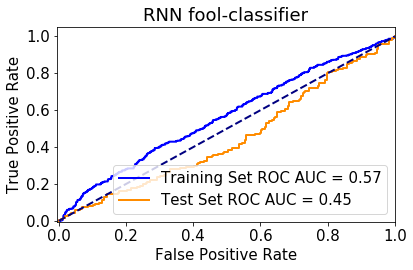

In [20]:
Y_true, Y_score = predict(training_dataloader_eval) 
roc_training, fpr_training, tpr_training = roc(Y_true, Y_score)
y_true, y_score = predict(test_dataloader_eval)
roc_test, fpr_test, tpr_test = roc(y_true, y_score)    

with open("/data/AIpep/auc_files/fool_classifier_hem.pkl","bw") as fd:
        pickle.dump((fpr_test, tpr_test), fd)

plt.figure()
name = "RNN fool-classifier"
plt.rcParams.update({'font.size': 15})
lw = 2
plt.plot(fpr_training, tpr_training, color='blue',
         lw=lw, label='Training Set ROC AUC = %0.2f' % roc_training)
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='Test Set ROC AUC = %0.2f' % roc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.005, 1.0])
plt.ylim([-0.005, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(name)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(folder+"plots/RNN-fool-classifier.svg")
plt.savefig("plots/RNN-fool-classifier.svg")
plt.show()